In [2]:
import os
os.environ['CASTLE_BACKEND'] = 'pytorch'

from collections import OrderedDict
import warnings

import numpy as np
import networkx as nx

import ges
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import IIDSimulation, DAG
from castle.algorithms import PC, ICALiNGAM, GOLEM

import matplotlib.pyplot as plt

[2022-06-22 18:26:48,738][__init__.py - line 31] - INFO - You are using ``pytorch`` as the backend.


In [3]:
# Mute warnings - for the sake of presentation clarity
# Should be removed for real-life applications
warnings.simplefilter('ignore')

# Causal Discovery in Python


Over the last decade, causal inference gained a lot of traction in academia and in the industry. Causal models can be immensely helpful in various areas – from marketing to medicine and from finance to cybersecurity. To make these models work, we need not only data as in traditional machine learning, but also a causal structure. Traditional way to obtain the latter is through well-designed experiments. Unfortunately, experiments can be tricky – difficult to design, expensive or unethical. Causal discovery (also known as structure learning) is an umbrella term that describes several families of methods aiming at discovering causal structure from observational data. During the talk, we will review the basics of causal inference and introduce the concept of causal discovery. Next, we will discuss differences between various approaches to causal discovery. Finally, we will see a series of practical examples of causal discovery using Python.

## Installing the environment

* Using **Conda**:

    `conda env create --file econml-dowhy-py38.yml`


* Installing `gcastle` only:

    `pip install gcastle==1.0.3rc3`

In [4]:
def get_n_undirected(g):
    
    total = 0
    
    for i in range(g.shape[0]):
        for j in range(g.shape[0]):
            if (g[i, j] == 1) and (g[i, j] == g[j, i]):
                total += .5
    
    return total

## PC algorithm

**PC algorithm** starts with a **fully connected** graph and then performs a series of steps to remove edges, based on graph independence structure. Finally, it tries to orient as many edges as possible.

Figure 1 presents a visual representatrion of these steps.

<br><br>

<img src="img/glymour_et_al_pc.jpg">

<br>

<figcaption><center><b>Figure 1. </b>Original graph and PC algorithm steps. (Gylmour et al., 2019)</center></figcaption>

<br>


Interested in more details? 
[Gylmour et al. - Review of Causal Discovery Methods Based on Graphical Models (2019)](https://www.frontiersin.org/articles/10.3389/fgene.2019.00524/full)

In [5]:
# Let's implement this structure
x = np.random.randn(1000)
y = np.random.randn(1000)

z = x + y + .1 * np.random.randn(1000)
w = .7 * z + .1 * np.random.randn(1000)

In [6]:
# To matrix
pc_dataset = np.vstack([x, y, z, w]).T

In [7]:
# Sanity check
pc_dataset, pc_dataset.shape

(array([[ 0.782,  0.652,  1.531,  1.032],
        [-1.124,  0.982, -0.154, -0.094],
        [-1.682, -2.048, -3.852, -2.582],
        ...,
        [ 0.084, -0.499, -0.317, -0.354],
        [-1.174,  0.902, -0.289, -0.013],
        [ 0.29 , -0.279, -0.067, -0.118]]),
 (1000, 4))

In [8]:
# Build the model
pc = PC()
pc.learn(pc_dataset)

In [9]:
pc.causal_matrix

Tensor([[0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 0]])

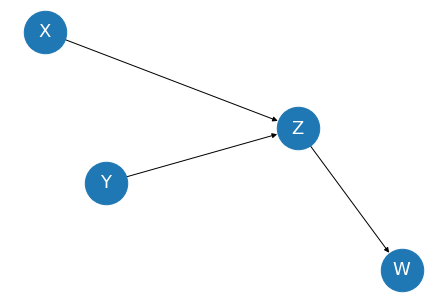

In [10]:
# Get learned graph
learned_graph = nx.DiGraph(pc.causal_matrix)

# Relabel the nodes
MAPPING = {k: v for k, v in zip(range(4), ['X', 'Y', 'Z', 'W'])}
learned_graph = nx.relabel_nodes(learned_graph, MAPPING, copy=True)

# Plot the graph
nx.draw(
    learned_graph, 
    with_labels=True,
    node_size=1800,
    font_size=18,
    font_color='white'
)

## Let's do some more discovery!

### Generate datasets

We'll use a [scale-free](https://en.wikipedia.org/wiki/Scale-free_network) model to generate graphs.

Then we'll use three different causal models on this graph:

* linear Gaussian
* linear exp
* non-linear quadratic

In [11]:
# Data simulation, simulate true causal dag and train_data.
true_dag = DAG.scale_free(n_nodes=10, n_edges=15, seed=18)


DATA_PARAMS = {
    'linearity': ['linear', 'nonlinear'], 
    'distribution': {
        'linear': ['gauss', 'exp'],
        'nonlinear': ['quadratic']
    }
}

datasets = {}

for linearity in DATA_PARAMS['linearity']:
    for distr in DATA_PARAMS['distribution'][linearity]:
        
        datasets[f'{linearity}_{distr}'] = IIDSimulation(
            W=true_dag, 
            n=2000, 
            method=linearity, 
            sem_type=distr)


[2022-06-22 18:34:07,246][simulator.py - line 270] - INFO - Finished synthetic dataset
[2022-06-22 18:34:07,246][simulator.py - line 270] - INFO - Finished synthetic dataset
[2022-06-22 18:34:07,260][simulator.py - line 270] - INFO - Finished synthetic dataset


In [12]:
# Sanity check
datasets

{'linear_gauss': <castle.datasets.simulator.IIDSimulation at 0x20dd312e130>,
 'linear_exp': <castle.datasets.simulator.IIDSimulation at 0x20dd311bc40>,
 'nonlinear_quadratic': <castle.datasets.simulator.IIDSimulation at 0x20deca41220>}

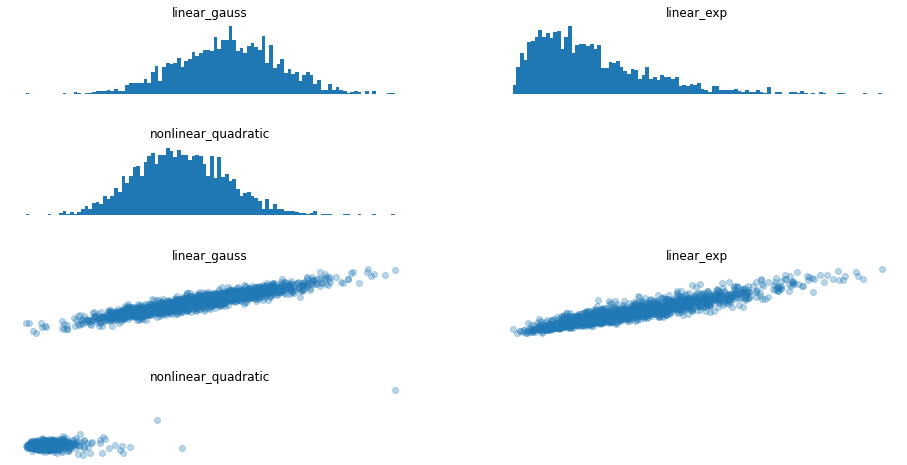

In [13]:
plt.figure(figsize=(16, 8))
for i, dataset in enumerate(datasets):
    X = datasets[dataset].X
    
    plt.subplot(4, 2, i + 1)
    plt.hist(X[:, 0], bins=100)
    plt.title(dataset)
    plt.axis('off')
    
    plt.subplot(4, 2, i + 5)
    plt.scatter(X[:, 8], X[:, 4], alpha=.3)
    plt.title(dataset)
    plt.axis('off')
    
plt.subplots_adjust(hspace=.7)
plt.show()

### Visualize the true graph

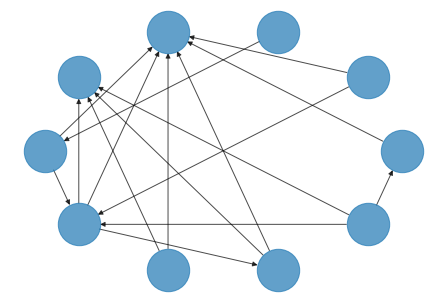

In [14]:
nx.draw(
    nx.DiGraph(true_dag), 
    node_size=1800,
    alpha=.7,
    pos=nx.circular_layout(nx.DiGraph(true_dag))
)

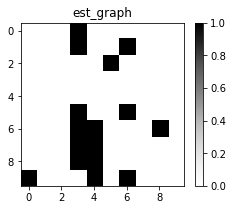

In [15]:
GraphDAG(true_dag)
plt.show()

## Method comparison 

In [16]:
methods = OrderedDict({
    'PC': PC,
    'GES': ges,
    'LiNGAM': ICALiNGAM,
    'GOLEM': GOLEM
})

************* Current dataset: linear_gauss

Method: PC


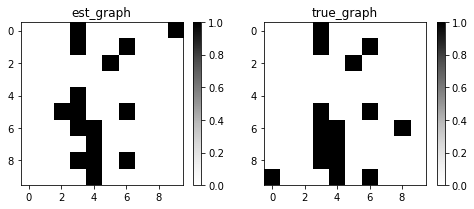

FDR: 0.2
Recall: 0.75
Precision: 0.75
F1 score: 0.75
No. of undir. edges: 1.0

-------------------------------------------------- 

Method: GES


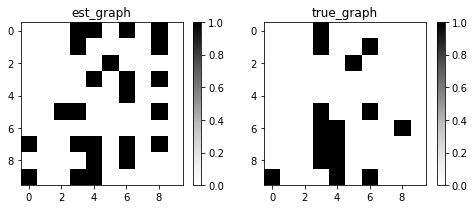

FDR: 0.6087
Recall: 0.5625
Precision: 0.375
F1 score: 0.45
No. of undir. edges: 1.0

-------------------------------------------------- 

Method: LiNGAM


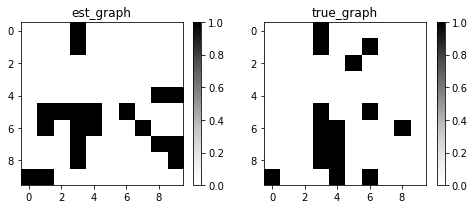

[2022-06-22 18:36:26,718][golem.py - line 204] - INFO - Started training for 25000 iterations.
[2022-06-22 18:36:26,774][golem.py - line 217] - INFO - [Iter 0] score=60.775, likelihood=60.775, h=0.0e+00


FDR: 0.55
Recall: 0.5625
Precision: 0.45
F1 score: 0.5
No. of undir. edges: 0

-------------------------------------------------- 

Method: GOLEM


[2022-06-22 18:36:35,184][golem.py - line 217] - INFO - [Iter 5000] score=49.805, likelihood=49.489, h=1.6e-04
[2022-06-22 18:36:43,176][golem.py - line 217] - INFO - [Iter 10000] score=49.804, likelihood=49.489, h=1.5e-04
[2022-06-22 18:36:51,027][golem.py - line 217] - INFO - [Iter 15000] score=49.804, likelihood=49.489, h=1.6e-04
[2022-06-22 18:36:59,019][golem.py - line 217] - INFO - [Iter 20000] score=49.804, likelihood=49.489, h=1.5e-04
[2022-06-22 18:37:06,997][golem.py - line 217] - INFO - [Iter 25000] score=49.804, likelihood=49.489, h=1.5e-04


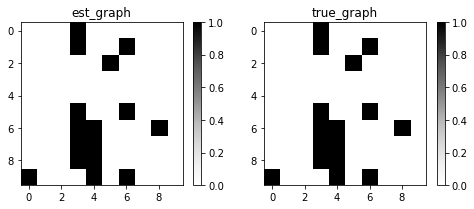

FDR: 0.0
Recall: 1.0
Precision: 1.0
F1 score: 1.0
No. of undir. edges: 0

-------------------------------------------------- 



************* Current dataset: linear_exp

Method: PC


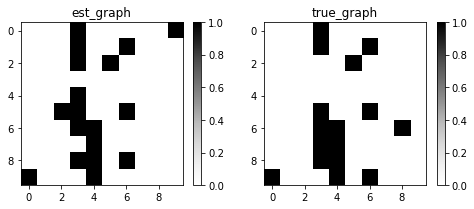

FDR: 0.1875
Recall: 0.8125
Precision: 0.7222
F1 score: 0.7647
No. of undir. edges: 2.0

-------------------------------------------------- 

Method: GES


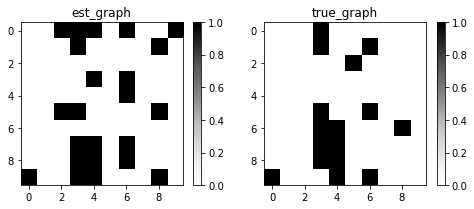

FDR: 0.5909
Recall: 0.5625
Precision: 0.3913
F1 score: 0.4615
No. of undir. edges: 1.0

-------------------------------------------------- 

Method: LiNGAM


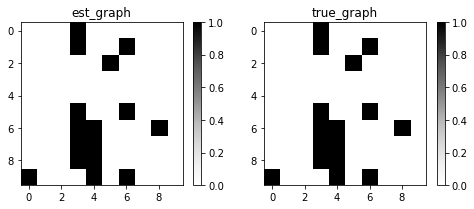

[2022-06-22 18:37:11,023][golem.py - line 204] - INFO - Started training for 25000 iterations.
[2022-06-22 18:37:11,023][golem.py - line 217] - INFO - [Iter 0] score=70.581, likelihood=70.581, h=0.0e+00


FDR: 0.0
Recall: 1.0
Precision: 1.0
F1 score: 1.0
No. of undir. edges: 0

-------------------------------------------------- 

Method: GOLEM


[2022-06-22 18:37:18,837][golem.py - line 217] - INFO - [Iter 5000] score=51.017, likelihood=50.664, h=2.2e-03
[2022-06-22 18:37:26,665][golem.py - line 217] - INFO - [Iter 10000] score=51.013, likelihood=50.660, h=2.1e-03
[2022-06-22 18:37:34,466][golem.py - line 217] - INFO - [Iter 15000] score=51.013, likelihood=50.660, h=2.2e-03
[2022-06-22 18:37:42,328][golem.py - line 217] - INFO - [Iter 20000] score=51.013, likelihood=50.660, h=2.2e-03
[2022-06-22 18:37:50,299][golem.py - line 217] - INFO - [Iter 25000] score=51.013, likelihood=50.660, h=2.2e-03


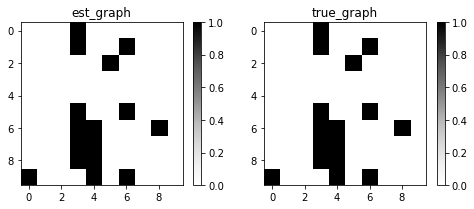

FDR: 0.0
Recall: 1.0
Precision: 1.0
F1 score: 1.0
No. of undir. edges: 0

-------------------------------------------------- 



************* Current dataset: nonlinear_quadratic

Method: PC


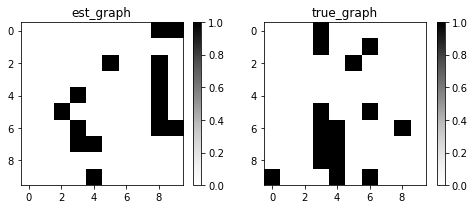

FDR: 0.5714
Recall: 0.375
Precision: 0.4
F1 score: 0.3871
No. of undir. edges: 1.0

-------------------------------------------------- 

Method: GES


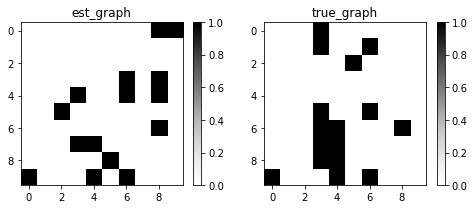

FDR: 0.5714
Recall: 0.375
Precision: 0.4
F1 score: 0.3871
No. of undir. edges: 1.0

-------------------------------------------------- 

Method: LiNGAM


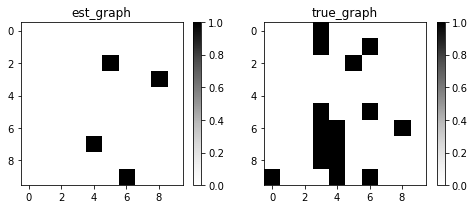

[2022-06-22 18:37:52,225][golem.py - line 204] - INFO - Started training for 25000 iterations.
[2022-06-22 18:37:52,225][golem.py - line 217] - INFO - [Iter 0] score=55.103, likelihood=55.103, h=0.0e+00


FDR: 0.25
Recall: 0.1875
Precision: 0.75
F1 score: 0.3
No. of undir. edges: 0

-------------------------------------------------- 

Method: GOLEM


[2022-06-22 18:38:00,325][golem.py - line 217] - INFO - [Iter 5000] score=53.118, likelihood=52.721, h=2.1e-02
[2022-06-22 18:38:08,400][golem.py - line 217] - INFO - [Iter 10000] score=53.118, likelihood=52.721, h=2.1e-02
[2022-06-22 18:38:16,277][golem.py - line 217] - INFO - [Iter 15000] score=53.118, likelihood=52.721, h=2.1e-02
[2022-06-22 18:38:24,084][golem.py - line 217] - INFO - [Iter 20000] score=53.118, likelihood=52.721, h=2.1e-02
[2022-06-22 18:38:31,891][golem.py - line 217] - INFO - [Iter 25000] score=53.118, likelihood=52.721, h=2.1e-02


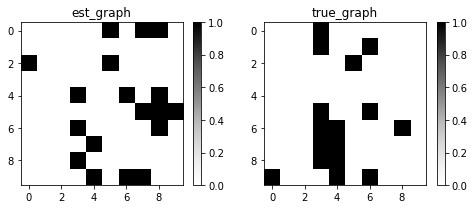

FDR: 0.6111
Recall: 0.4375
Precision: 0.3889
F1 score: 0.4118
No. of undir. edges: 0

-------------------------------------------------- 



Wall time: 2min 10s


In [17]:
%%time

results = {}

for k, dataset in datasets.items():
    print(f'************* Current dataset: {k}\n')
    X = dataset.X
    
    results[dataset] = {}
    
    for method in methods:
        
        if method not in ['GES', 'CORL']:
            print(f'Method: {method}')
            
            # Fit the model
            if method == 'GOLEM':
                model = methods[method](num_iter=2.5e4)
            else:
                model = methods[method]()
            
            model.learn(X)
            
            pred_dag = model.causal_matrix

        elif method == 'GES':
            print(f'Method: {method}')
            
            # Fit the model
            pred_dag, _ = methods[method].fit_bic(X)
              
        # Get n undir edges
        n_undir = get_n_undirected(pred_dag)

        # Plot results
        GraphDAG(pred_dag, true_dag, 'result')

        mt = MetricsDAG(pred_dag, true_dag)
        print(f'FDR: {mt.metrics["fdr"]}')
        print(f'Recall: {mt.metrics["recall"]}')
        print(f'Precision: {mt.metrics["precision"]}')
        print(f'F1 score: {mt.metrics["F1"]}')
        print(f'No. of undir. edges: {n_undir}\n')
        print('-' * 50, '\n')

        results[dataset][method] = pred_dag      
            
    print('\n')         